In [1]:
import torch
import torch.nn as nn

class YoloLoss(nn.Module):
    def __init__(self, S=7, B=2, C=20, λ_coord=5, λ_noobj=0.5):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")
        self.S = S
        self.B = B
        self.C = C
        self.lambda_coord = λ_coord
        self.lambda_noobj = λ_noobj

    def forward(self, predictions, target):
        # Reshape to [batch_size, S, S, (C + B*5)]
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

        # --- 1️⃣ Identify cells containing objects ---
        obj_mask = target[..., self.C + 4].unsqueeze(-1)  # 1 if object present

        # --- 2️⃣ Localization loss ---
        box_pred = predictions[..., self.C:self.C + 5]
        box_target = target[..., self.C:self.C + 5]

        # Only for cells containing object
        box_pred_xy = obj_mask * box_pred[..., :2]
        box_target_xy = obj_mask * box_target[..., :2]

        box_pred_wh = obj_mask * torch.sign(box_pred[..., 2:4]) * torch.sqrt(torch.abs(box_pred[..., 2:4] + 1e-6))
        box_target_wh = obj_mask * torch.sqrt(box_target[..., 2:4])

        coord_loss = self.mse(box_pred_xy, box_target_xy) + self.mse(box_pred_wh, box_target_wh)
        coord_loss = self.lambda_coord * coord_loss

        # --- 3️⃣ Object confidence loss ---
        conf_pred = predictions[..., self.C + 4]
        conf_target = target[..., self.C + 4]

        obj_conf_loss = self.mse(obj_mask.squeeze(-1) * conf_pred, obj_mask.squeeze(-1) * conf_target)

        # --- 4️⃣ No object confidence loss ---
        noobj_mask = 1 - obj_mask
        noobj_conf_loss = self.mse(noobj_mask.squeeze(-1) * conf_pred, noobj_mask.squeeze(-1) * conf_target)
        noobj_conf_loss = self.lambda_noobj * noobj_conf_loss

        # --- 5️⃣ Classification loss ---
        class_pred = predictions[..., :self.C]
        class_target = target[..., :self.C]

        class_loss = self.mse(obj_mask * class_pred, obj_mask * class_target)

        # --- Final total loss ---
        total_loss = coord_loss + obj_conf_loss + noobj_conf_loss + class_loss
        return total_loss


In [2]:
loss_fn = YoloLoss(S=7, B=2, C=20)
preds = torch.rand((1, 7*7*(20 + 2*5)))  # output from model
target = torch.rand((1, 7, 7, 30))
loss = loss_fn(preds, target)
print("Loss:", loss.item())

Loss: 120.31439971923828


In [3]:
def forward(self, predictions, target):
        # Reshape to [batch_size, S, S, (C + B*5)]
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)
        # Yahan:
        # predictions ek bada tensor hoga (model ka output)
        # self.S — grid size hoti hai (YOLO me jaise 7x7)
        # self.B — bounding boxes per grid cell (usually 2)
        # self.C — classes ki sankhya (e.g., 20 for VOC dataset)
        # -1 — automatically dimension adjust kar do (PyTorch/Numpy khud calculate karega)    
        # YOLO jaise models output dete hain ek flat tensor me.
        # Par hume us output ko reshape karna padta hai taki har grid cell ka prediction alag se mil jaye.
        # To agar tumhara model output hai (batch_size, S*S*(C + B*5)),
        # to reshape karke hum usse (batch_size, S, S, C + B*5) me badalte hain
        # taki har grid cell ke andar ke prediction (classes + bounding boxes) ko access kar sakein.

In [4]:
# predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)
import numpy as np

a = np.array([1, 2, 3, 4, 5, 6])

a.reshape(2, 3)
# Matlab: usi data ko 2 rows aur 3 columns me organize kar diya gaya.

array([[1, 2, 3],
       [4, 5, 6]])

In [5]:
# obj_mask = target[..., self.C + 4].unsqueeze(-1)

# YOLO ka target tensor shape hota hai:
        # (S, S, C + 5*B)
        # Agar hum YOLOv1 ki baat karein:
        # S = 7 (grid size)
        # B = 2 (bounding boxes per cell)
        # C = 20 (class categories)
        # To har cell ke liye total output hota hai:
        # C + 5*B = 20 + 10 = 30 features

        # Ek grid cell ke andar values kuch aise hoti hain:
        # [ x, y, w, h, conf, class_1, class_2, ..., class_20,  x2, y2, w2, h2, conf2 ]

        # target[..., self.C + 4] means self.C + 4 = 20 + 4 = 24
        # → ye 24th index hai (0-based indexing), jo represent karta hai pehle bounding box ka confidence score.
        # yaani har cell me agar object present hai, to is position par 1 hoga,
        # aur agar koi object nahi hai, to 0 hoga.

        # .unsqueeze(-1)
        # iska matlab hai tensor ke end me ek extra dimension jod dena,
        # taaki broadcasting me problem na aaye jab hum is mask ko multiply karenge predictions ke saath.
        # Before unsqueeze : (7, 7)	
        # Shape	: mask without extra dim
        # After unsqueeze : (7, 7, 1)

        # 👉 obj_mask ek boolean/tensor mask hai jo batata hai:
        # kis grid cell me object present hai (1)
        # aur kis me nahi (0)

In [6]:
# box_pred = predictions[..., self.C:self.C + 5]
# box_target = target[..., self.C:self.C + 5]

In [7]:
# predictions aur target ka shape ho sakta hai (batch_size, S, S, C + B*5)

# S x S → grid

# C → class probabilities

# B*5 → bounding boxes per cell (x, y, w, h, conf)

# [..., self.C:self.C + 5] ka matlab:

# ... → baki dimensions ko as it is rakho

# self.C:self.C + 5 → class probabilities ke baad ke first bounding box ke (x, y, w, h, conf) values ko select karo

# ⚡ Intuition:

# Hum localization loss calculate kar rahe hain, matlab bounding box ki accuracy (x, y, w, h) aur confidence ke liye.

# Class probabilities (class_1 ... class_C) ko is step me ignore kar rahe hain.

In [8]:
import numpy as np
# --- Parameters ---
S = 7   # grid size (3x3)
C = 20   # number of classes
B = 2   # boxes per grid cell

In [9]:
# --- Simulate predictions tensor ---
# Shape: (batch_size, S, S, C + B*5)
batch_size = 1
# predictions = torch.randint(batch_size, S, S, C + B*5)

predictions = torch.rand(batch_size, S, S, C + B * 5)

In [10]:
predictions

tensor([[[[0.0097, 0.1076, 0.7399,  ..., 0.2689, 0.1627, 0.8524],
          [0.6793, 0.5461, 0.4115,  ..., 0.2379, 0.3002, 0.0493],
          [0.3027, 0.2942, 0.1122,  ..., 0.6495, 0.6698, 0.0803],
          ...,
          [0.8246, 0.4685, 0.5889,  ..., 0.9283, 0.7085, 0.3872],
          [0.2672, 0.6733, 0.1855,  ..., 0.9547, 0.9579, 0.1569],
          [0.7046, 0.4012, 0.6767,  ..., 0.0017, 0.0250, 0.0462]],

         [[0.6970, 0.3432, 0.5100,  ..., 0.8304, 0.1528, 0.3713],
          [0.5373, 0.3963, 0.7419,  ..., 0.3714, 0.7719, 0.6154],
          [0.2073, 0.2567, 0.2027,  ..., 0.5950, 0.3125, 0.1057],
          ...,
          [0.9088, 0.5745, 0.8108,  ..., 0.6023, 0.3340, 0.2226],
          [0.6111, 0.3920, 0.7266,  ..., 0.2175, 0.5934, 0.6326],
          [0.5529, 0.7959, 0.2116,  ..., 0.5820, 0.2604, 0.6874]],

         [[0.0842, 0.0703, 0.5286,  ..., 0.4853, 0.3565, 0.9486],
          [0.0043, 0.0682, 0.7864,  ..., 0.7645, 0.6618, 0.6272],
          [0.3058, 0.2731, 0.3124,  ..., 0

In [11]:
predictions.shape

torch.Size([1, 7, 7, 30])

In [12]:
# For illustration, let's assume first grid cell
print("Predictions for first cell:\n", predictions[0,0,0])

Predictions for first cell:
 tensor([0.0097, 0.1076, 0.7399, 0.3562, 0.0233, 0.9836, 0.9524, 0.9860, 0.6349,
        0.7254, 0.7752, 0.2949, 0.9010, 0.5256, 0.1335, 0.4539, 0.7736, 0.1493,
        0.9846, 0.8535, 0.2495, 0.8205, 0.0665, 0.1949, 0.6236, 0.5985, 0.8134,
        0.2689, 0.1627, 0.8524])


In [13]:
# --- Extract first bounding box ---
# class probabilities are first C values, then boxes
box_pred = predictions[..., C:C+5]
print("\nFirst bounding box prediction (x, y, w, h, conf):\n", box_pred[0,0,0])


First bounding box prediction (x, y, w, h, conf):
 tensor([0.2495, 0.8205, 0.0665, 0.1949, 0.6236])


In [14]:
# --- Extract second bounding box ---
box_pred2 = predictions[..., C+5:C+10]
print("\nSecond bounding box prediction (x2, y2, w2, h2, conf2):\n", box_pred2[0,0,0])


Second bounding box prediction (x2, y2, w2, h2, conf2):
 tensor([0.5985, 0.8134, 0.2689, 0.1627, 0.8524])


In [15]:
# --- Extract class probabilities ---
class_probs = predictions[..., :C]
print("\nClass probabilities for first cell:\n", class_probs[0,0,0])


Class probabilities for first cell:
 tensor([0.0097, 0.1076, 0.7399, 0.3562, 0.0233, 0.9836, 0.9524, 0.9860, 0.6349,
        0.7254, 0.7752, 0.2949, 0.9010, 0.5256, 0.1335, 0.4539, 0.7736, 0.1493,
        0.9846, 0.8535])


In [16]:
# Explanation:
# predictions ka shape: (batch_size, S, S, C + B*5)
# C → class probabilities
# B*5 → bounding boxes (x, y, w, h, conf)
# C:C+5 → first bounding box ke x, y, w, h, conf
# C+5:C+10 → second bounding box ke values
# :C → class probabilities

In [17]:
# Target
# box_target = target[..., C:C+5]    # first bounding box same as above

In [18]:
# Only for cells containing object
# box_pred_xy = obj_mask * box_pred[..., :2]
# box_target_xy = obj_mask * box_target[..., :2]

# Context: YOLO Localization Loss
# box_pred → predicted bounding boxes [x, y, w, h, conf]
# box_target → ground truth boxes [x, y, w, h, conf]

In [19]:
# obj_mask ab ek binary mask hai jo sirf un grid cells ko 1 deta hai jahan object hai, baki 0.

In [20]:
# box_pred[..., :2] → predicted x, y

# box_target[..., :2] → ground truth x, y

# * obj_mask → multiply by mask:

# Object present → value remains

# Object absent → value becomes 0, loss ignore ho jata hai

# ⚡ Intuition:

# Hum loss sirf objects ke liye calculate kar rahe hain, background cells ke liye ignore kar rahe hain.

# Ye YOLO me important step hai, warna background cells ka meaningless bounding box loss model ko confuse karega.

In [21]:
predictions

tensor([[[[0.0097, 0.1076, 0.7399,  ..., 0.2689, 0.1627, 0.8524],
          [0.6793, 0.5461, 0.4115,  ..., 0.2379, 0.3002, 0.0493],
          [0.3027, 0.2942, 0.1122,  ..., 0.6495, 0.6698, 0.0803],
          ...,
          [0.8246, 0.4685, 0.5889,  ..., 0.9283, 0.7085, 0.3872],
          [0.2672, 0.6733, 0.1855,  ..., 0.9547, 0.9579, 0.1569],
          [0.7046, 0.4012, 0.6767,  ..., 0.0017, 0.0250, 0.0462]],

         [[0.6970, 0.3432, 0.5100,  ..., 0.8304, 0.1528, 0.3713],
          [0.5373, 0.3963, 0.7419,  ..., 0.3714, 0.7719, 0.6154],
          [0.2073, 0.2567, 0.2027,  ..., 0.5950, 0.3125, 0.1057],
          ...,
          [0.9088, 0.5745, 0.8108,  ..., 0.6023, 0.3340, 0.2226],
          [0.6111, 0.3920, 0.7266,  ..., 0.2175, 0.5934, 0.6326],
          [0.5529, 0.7959, 0.2116,  ..., 0.5820, 0.2604, 0.6874]],

         [[0.0842, 0.0703, 0.5286,  ..., 0.4853, 0.3565, 0.9486],
          [0.0043, 0.0682, 0.7864,  ..., 0.7645, 0.6618, 0.6272],
          [0.3058, 0.2731, 0.3124,  ..., 0

In [22]:
# --- Fake target tensor ---
target = torch.zeros_like(predictions)
target

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 

In [23]:
# Let's assume object is present only in cell (0,1)
# Set confidence = 1 for first box in that cell
target[0, 0, 1, C + 4] = 1 

In [24]:
# Set some target x, y for demonstration
# ✅ Option 1: convert list to tensor
target[0, 0, 1, C:C+2] = torch.tensor([0.5, 0.7])

In [25]:
# --- Extract boxes ---
box_pred = predictions[..., C:C+5]    # x, y, w, h, conf
box_target = target[..., C:C+5]

In [26]:
box_pred

tensor([[[[0.2495, 0.8205, 0.0665, 0.1949, 0.6236],
          [0.9791, 0.3004, 0.0054, 0.4333, 0.9510],
          [0.8773, 0.8971, 0.6374, 0.2554, 0.2045],
          [0.0250, 0.5945, 0.9611, 0.7737, 0.1117],
          [0.6932, 0.9202, 0.3417, 0.9364, 0.2828],
          [0.7936, 0.8412, 0.4906, 0.7458, 0.0508],
          [0.4513, 0.1053, 0.9849, 0.6323, 0.8200]],

         [[0.8542, 0.3592, 0.2442, 0.8576, 0.4013],
          [0.6431, 0.6822, 0.9891, 0.8002, 0.0589],
          [0.1837, 0.5664, 0.4157, 0.6032, 0.8803],
          [0.6631, 0.8759, 0.3601, 0.4437, 0.1266],
          [0.7375, 0.5989, 0.6617, 0.2975, 0.0539],
          [0.0010, 0.2041, 0.4688, 0.7605, 0.5432],
          [0.6834, 0.4520, 0.6816, 0.3053, 0.8431]],

         [[0.8768, 0.7049, 0.8971, 0.4622, 0.3499],
          [0.7965, 0.8327, 0.6634, 0.3516, 0.9917],
          [0.2600, 0.4663, 0.6324, 0.1582, 0.2080],
          [0.1081, 0.5436, 0.8716, 0.6981, 0.4383],
          [0.8217, 0.1495, 0.9397, 0.1071, 0.0771],
        

In [27]:
box_target

tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.5000, 0.7000, 0.0000, 0.0000, 1.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        

In [28]:
# --- Create object mask ---
obj_mask = target[..., C + 4: C + 5]  # keep last dim, shape: (batch, S, S, 1)
obj_mask

tensor([[[[0.],
          [1.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.]]]])

In [29]:
box_pred[..., :2]
# So this extracts only the first two values (x, y coordinates) from each 5-element vector.

tensor([[[[0.2495, 0.8205],
          [0.9791, 0.3004],
          [0.8773, 0.8971],
          [0.0250, 0.5945],
          [0.6932, 0.9202],
          [0.7936, 0.8412],
          [0.4513, 0.1053]],

         [[0.8542, 0.3592],
          [0.6431, 0.6822],
          [0.1837, 0.5664],
          [0.6631, 0.8759],
          [0.7375, 0.5989],
          [0.0010, 0.2041],
          [0.6834, 0.4520]],

         [[0.8768, 0.7049],
          [0.7965, 0.8327],
          [0.2600, 0.4663],
          [0.1081, 0.5436],
          [0.8217, 0.1495],
          [0.4177, 0.3961],
          [0.1153, 0.9884]],

         [[0.3898, 0.9095],
          [0.6419, 0.7316],
          [0.7081, 0.2066],
          [0.7247, 0.4753],
          [0.1269, 0.5820],
          [0.0022, 0.7636],
          [0.9560, 0.7818]],

         [[0.4002, 0.2960],
          [0.7276, 0.0932],
          [0.1938, 0.2975],
          [0.3536, 0.1397],
          [0.3440, 0.6646],
          [0.2591, 0.6478],
          [0.8602, 0.7451]],

         [

In [30]:
box_pred_xy = obj_mask * box_pred[..., :2]
box_pred_xy
# → Sirf un cells ke liye compare karo jahan object hai.
# (Background cells ka contribution zero kar diya mask se.)

tensor([[[[0.0000, 0.0000],
          [0.9791, 0.3004],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],

         [[0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],

         [[0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],

         [[0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],

         [[0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],

         [

In [31]:
box_target_xy = obj_mask * box_target[..., :2]
box_target_xy

tensor([[[[0.0000, 0.0000],
          [0.5000, 0.7000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],

         [[0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],

         [[0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],

         [[0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],

         [[0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],

         [

In [32]:
box_pred[..., 2:4]
# Ye box_pred ke last dimension ke index 2 aur 3 (width, height) nikalta hai.

tensor([[[[0.0665, 0.1949],
          [0.0054, 0.4333],
          [0.6374, 0.2554],
          [0.9611, 0.7737],
          [0.3417, 0.9364],
          [0.4906, 0.7458],
          [0.9849, 0.6323]],

         [[0.2442, 0.8576],
          [0.9891, 0.8002],
          [0.4157, 0.6032],
          [0.3601, 0.4437],
          [0.6617, 0.2975],
          [0.4688, 0.7605],
          [0.6816, 0.3053]],

         [[0.8971, 0.4622],
          [0.6634, 0.3516],
          [0.6324, 0.1582],
          [0.8716, 0.6981],
          [0.9397, 0.1071],
          [0.8042, 0.9163],
          [0.9513, 0.7884]],

         [[0.7559, 0.8480],
          [0.0411, 0.1615],
          [0.6222, 0.7308],
          [0.3704, 0.5591],
          [0.8460, 0.8116],
          [0.2836, 0.8180],
          [0.1913, 0.5878]],

         [[0.8208, 0.7369],
          [0.8502, 0.2270],
          [0.3754, 0.6008],
          [0.8789, 0.2399],
          [0.3959, 0.2818],
          [0.1107, 0.4471],
          [0.0920, 0.5947]],

         [

In [33]:
torch.sign(box_pred[..., 2:4])

tensor([[[[1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.]],

         [[1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.]],

         [[1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.]],

         [[1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.]],

         [[1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.]],

         [[1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.]],

         [[1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.],
          [1., 1.]]]])

In [34]:
torch.abs(box_pred[..., 2:4] + 1e-6)

tensor([[[[0.0665, 0.1949],
          [0.0054, 0.4333],
          [0.6374, 0.2554],
          [0.9611, 0.7738],
          [0.3417, 0.9364],
          [0.4907, 0.7458],
          [0.9849, 0.6323]],

         [[0.2442, 0.8576],
          [0.9891, 0.8002],
          [0.4157, 0.6032],
          [0.3601, 0.4437],
          [0.6617, 0.2975],
          [0.4688, 0.7605],
          [0.6816, 0.3053]],

         [[0.8971, 0.4622],
          [0.6634, 0.3516],
          [0.6324, 0.1582],
          [0.8717, 0.6981],
          [0.9397, 0.1071],
          [0.8042, 0.9163],
          [0.9513, 0.7884]],

         [[0.7559, 0.8480],
          [0.0411, 0.1615],
          [0.6222, 0.7308],
          [0.3704, 0.5591],
          [0.8460, 0.8116],
          [0.2836, 0.8180],
          [0.1913, 0.5878]],

         [[0.8208, 0.7369],
          [0.8502, 0.2270],
          [0.3754, 0.6008],
          [0.8789, 0.2399],
          [0.3959, 0.2818],
          [0.1107, 0.4471],
          [0.0920, 0.5948]],

         [

In [35]:
torch.sqrt(torch.abs(box_pred[..., 2:4] + 1e-6))

tensor([[[[0.2579, 0.4415],
          [0.0732, 0.6582],
          [0.7984, 0.5054],
          [0.9804, 0.8796],
          [0.5846, 0.9677],
          [0.7005, 0.8636],
          [0.9924, 0.7952]],

         [[0.4941, 0.9261],
          [0.9946, 0.8946],
          [0.6447, 0.7766],
          [0.6001, 0.6661],
          [0.8134, 0.5454],
          [0.6847, 0.8721],
          [0.8256, 0.5526]],

         [[0.9471, 0.6798],
          [0.8145, 0.5930],
          [0.7952, 0.3978],
          [0.9336, 0.8355],
          [0.9694, 0.3273],
          [0.8968, 0.9572],
          [0.9754, 0.8879]],

         [[0.8694, 0.9209],
          [0.2027, 0.4019],
          [0.7888, 0.8549],
          [0.6086, 0.7477],
          [0.9198, 0.9009],
          [0.5325, 0.9044],
          [0.4373, 0.7667]],

         [[0.9060, 0.8584],
          [0.9221, 0.4765],
          [0.6127, 0.7751],
          [0.9375, 0.4898],
          [0.6292, 0.5309],
          [0.3327, 0.6686],
          [0.3034, 0.7712]],

         [

In [36]:
obj_mask * torch.sign(box_pred[..., 2:4])

tensor([[[[0., 0.],
          [1., 1.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.]]]])

In [37]:
obj_mask * torch.sign(box_pred[..., 2:4]) * torch.sqrt(torch.abs(box_pred[..., 2:4] + 1e-6))

tensor([[[[0.0000, 0.0000],
          [0.0732, 0.6582],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],

         [[0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],

         [[0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],

         [[0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],

         [[0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],

         [

In [38]:
box_pred_wh = obj_mask * torch.sign(box_pred[..., 2:4]) * torch.sqrt(torch.abs(box_pred[..., 2:4] + 1e-6))
box_pred_wh

tensor([[[[0.0000, 0.0000],
          [0.0732, 0.6582],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],

         [[0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],

         [[0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],

         [[0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],

         [[0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000],
          [0.0000, 0.0000]],

         [

In [39]:
torch.sqrt(box_target[..., 2:4])

tensor([[[[0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.]]]])

In [40]:
obj_mask * torch.sqrt(box_target[..., 2:4])

tensor([[[[0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.]]]])

In [41]:
box_target_wh = obj_mask * torch.sqrt(box_target[..., 2:4])
box_target_wh

tensor([[[[0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.],
          [0., 0.]]]])

In [42]:
# box_pred_wh = masked predicted width–height values (with sign + sqrt transformation)
# box_target_wh = masked ground truth width–height (only sqrt, since target values positive hoti hain)

In [43]:
mse = nn.MSELoss(reduction="sum")

In [44]:
mse(box_pred_xy, box_target_xy)

tensor(0.3892)

In [45]:
mse(box_pred_wh, box_target_wh)

tensor(0.4387)

In [46]:
# Combine XY + WH Loss
coord_loss = mse(box_pred_xy, box_target_xy) + mse(box_pred_wh, box_target_wh)
coord_loss

# Dono parts add karke overall localization loss banta hai.
# λ_coord = 5 multiply karke usko emphasize karte hain.

tensor(0.8279)

In [47]:
lambda_coord = 5
coord_loss = lambda_coord * coord_loss
coord_loss

tensor(4.1394)

In [48]:
predictions

tensor([[[[0.0097, 0.1076, 0.7399,  ..., 0.2689, 0.1627, 0.8524],
          [0.6793, 0.5461, 0.4115,  ..., 0.2379, 0.3002, 0.0493],
          [0.3027, 0.2942, 0.1122,  ..., 0.6495, 0.6698, 0.0803],
          ...,
          [0.8246, 0.4685, 0.5889,  ..., 0.9283, 0.7085, 0.3872],
          [0.2672, 0.6733, 0.1855,  ..., 0.9547, 0.9579, 0.1569],
          [0.7046, 0.4012, 0.6767,  ..., 0.0017, 0.0250, 0.0462]],

         [[0.6970, 0.3432, 0.5100,  ..., 0.8304, 0.1528, 0.3713],
          [0.5373, 0.3963, 0.7419,  ..., 0.3714, 0.7719, 0.6154],
          [0.2073, 0.2567, 0.2027,  ..., 0.5950, 0.3125, 0.1057],
          ...,
          [0.9088, 0.5745, 0.8108,  ..., 0.6023, 0.3340, 0.2226],
          [0.6111, 0.3920, 0.7266,  ..., 0.2175, 0.5934, 0.6326],
          [0.5529, 0.7959, 0.2116,  ..., 0.5820, 0.2604, 0.6874]],

         [[0.0842, 0.0703, 0.5286,  ..., 0.4853, 0.3565, 0.9486],
          [0.0043, 0.0682, 0.7864,  ..., 0.7645, 0.6618, 0.6272],
          [0.3058, 0.2731, 0.3124,  ..., 0

In [49]:
conf_pred = predictions[..., C + 4]
conf_pred

tensor([[[0.6236, 0.9510, 0.2045, 0.1117, 0.2828, 0.0508, 0.8200],
         [0.4013, 0.0589, 0.8803, 0.1266, 0.0539, 0.5432, 0.8431],
         [0.3499, 0.9917, 0.2080, 0.4383, 0.0771, 0.2520, 0.2773],
         [0.3599, 0.9927, 0.9979, 0.3712, 0.6358, 0.1831, 0.1642],
         [0.2070, 0.6595, 0.2139, 0.2296, 0.9333, 0.6213, 0.6643],
         [0.7815, 0.6587, 0.8903, 0.8620, 0.0820, 0.3402, 0.3068],
         [0.0264, 0.4826, 0.2851, 0.6372, 0.0854, 0.8719, 0.2445]]])

In [50]:
conf_target = target[..., C + 4]
conf_target

tensor([[[0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.]]])

In [51]:
obj_mask

tensor([[[[0.],
          [1.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.]]]])

In [52]:
obj_mask.squeeze(-1)
# removes dimension

tensor([[[0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.]]])

In [53]:
obj_mask.squeeze(-1) * conf_pred

tensor([[[0.0000, 0.9510, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]])

In [54]:
obj_mask.squeeze(-1)

tensor([[[0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.]]])

In [55]:
obj_mask.squeeze(-1) * conf_target

tensor([[[0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.]]])

In [56]:
mse(obj_mask.squeeze(-1) * conf_pred, obj_mask.squeeze(-1) * conf_target)

tensor(0.0024)

In [57]:
obj_conf_loss = mse(obj_mask.squeeze(-1) * conf_pred, obj_mask.squeeze(-1) * conf_target)
obj_conf_loss

tensor(0.0024)

In [58]:
noobj_mask = 1 - obj_mask
noobj_mask

tensor([[[[1.],
          [0.],
          [1.],
          [1.],
          [1.],
          [1.],
          [1.]],

         [[1.],
          [1.],
          [1.],
          [1.],
          [1.],
          [1.],
          [1.]],

         [[1.],
          [1.],
          [1.],
          [1.],
          [1.],
          [1.],
          [1.]],

         [[1.],
          [1.],
          [1.],
          [1.],
          [1.],
          [1.],
          [1.]],

         [[1.],
          [1.],
          [1.],
          [1.],
          [1.],
          [1.],
          [1.]],

         [[1.],
          [1.],
          [1.],
          [1.],
          [1.],
          [1.],
          [1.]],

         [[1.],
          [1.],
          [1.],
          [1.],
          [1.],
          [1.],
          [1.]]]])

In [59]:
noobj_mask.squeeze(-1)

tensor([[[1., 0., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1.]]])

In [60]:
noobj_mask.squeeze(-1) * conf_pred

tensor([[[0.6236, 0.0000, 0.2045, 0.1117, 0.2828, 0.0508, 0.8200],
         [0.4013, 0.0589, 0.8803, 0.1266, 0.0539, 0.5432, 0.8431],
         [0.3499, 0.9917, 0.2080, 0.4383, 0.0771, 0.2520, 0.2773],
         [0.3599, 0.9927, 0.9979, 0.3712, 0.6358, 0.1831, 0.1642],
         [0.2070, 0.6595, 0.2139, 0.2296, 0.9333, 0.6213, 0.6643],
         [0.7815, 0.6587, 0.8903, 0.8620, 0.0820, 0.3402, 0.3068],
         [0.0264, 0.4826, 0.2851, 0.6372, 0.0854, 0.8719, 0.2445]]])

In [61]:
noobj_mask.squeeze(-1)

tensor([[[1., 0., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1.]]])

In [62]:
noobj_mask.squeeze(-1) * conf_target

tensor([[[0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.]]])

In [63]:
mse(noobj_mask.squeeze(-1) * conf_pred, noobj_mask.squeeze(-1) * conf_target)

tensor(13.9830)

In [64]:
noobj_conf_loss = mse(noobj_mask.squeeze(-1) * conf_pred, noobj_mask.squeeze(-1) * conf_target)
noobj_conf_loss

tensor(13.9830)

In [65]:
lambda_noobj = 0.5
noobj_conf_loss = lambda_noobj * noobj_conf_loss
noobj_conf_loss

tensor(6.9915)

In [66]:
predictions[..., :C]

tensor([[[[0.0097, 0.1076, 0.7399, 0.3562, 0.0233, 0.9836, 0.9524, 0.9860,
           0.6349, 0.7254, 0.7752, 0.2949, 0.9010, 0.5256, 0.1335, 0.4539,
           0.7736, 0.1493, 0.9846, 0.8535],
          [0.6793, 0.5461, 0.4115, 0.4180, 0.4969, 0.3171, 0.2328, 0.4700,
           0.6883, 0.0337, 0.3451, 0.2128, 0.8505, 0.3494, 0.3517, 0.9344,
           0.6071, 0.0061, 0.9463, 0.2013],
          [0.3027, 0.2942, 0.1122, 0.1634, 0.0277, 0.1544, 0.7292, 0.3056,
           0.3405, 0.9920, 0.9624, 0.0195, 0.4397, 0.0669, 0.6761, 0.1852,
           0.6784, 0.0672, 0.5649, 0.9659],
          [0.3523, 0.8987, 0.8552, 0.9696, 0.6375, 0.5338, 0.5939, 0.1168,
           0.8719, 0.5520, 0.1494, 0.7642, 0.2812, 0.8992, 0.9884, 0.5659,
           0.8686, 0.7298, 0.1104, 0.3526],
          [0.8246, 0.4685, 0.5889, 0.3007, 0.0284, 0.3159, 0.3995, 0.5065,
           0.9697, 0.9947, 0.4440, 0.5038, 0.7396, 0.3555, 0.5016, 0.9968,
           0.6673, 0.1167, 0.0011, 0.4921],
          [0.2672, 0.6733, 0.1

In [67]:
# class_pred & class_target

# predictions[..., :self.C] → predicted class probabilities for each grid cell
# Last dimension ke first C elements (0 → C-1) class scores hote hain
# Example: C = 20 → predictions[..., 0:20]
# target[..., :self.C] → ground-truth class labels in one-hot format

# 1 → class present
# 0 → class not present
class_pred = predictions[..., :C]
class_pred

tensor([[[[0.0097, 0.1076, 0.7399, 0.3562, 0.0233, 0.9836, 0.9524, 0.9860,
           0.6349, 0.7254, 0.7752, 0.2949, 0.9010, 0.5256, 0.1335, 0.4539,
           0.7736, 0.1493, 0.9846, 0.8535],
          [0.6793, 0.5461, 0.4115, 0.4180, 0.4969, 0.3171, 0.2328, 0.4700,
           0.6883, 0.0337, 0.3451, 0.2128, 0.8505, 0.3494, 0.3517, 0.9344,
           0.6071, 0.0061, 0.9463, 0.2013],
          [0.3027, 0.2942, 0.1122, 0.1634, 0.0277, 0.1544, 0.7292, 0.3056,
           0.3405, 0.9920, 0.9624, 0.0195, 0.4397, 0.0669, 0.6761, 0.1852,
           0.6784, 0.0672, 0.5649, 0.9659],
          [0.3523, 0.8987, 0.8552, 0.9696, 0.6375, 0.5338, 0.5939, 0.1168,
           0.8719, 0.5520, 0.1494, 0.7642, 0.2812, 0.8992, 0.9884, 0.5659,
           0.8686, 0.7298, 0.1104, 0.3526],
          [0.8246, 0.4685, 0.5889, 0.3007, 0.0284, 0.3159, 0.3995, 0.5065,
           0.9697, 0.9947, 0.4440, 0.5038, 0.7396, 0.3555, 0.5016, 0.9968,
           0.6673, 0.1167, 0.0011, 0.4921],
          [0.2672, 0.6733, 0.1

In [68]:
target[..., :C]

tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [69]:
class_target = target[..., :C]
class_target

tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [70]:
class_loss = mse(obj_mask * class_pred, obj_mask * class_target)
# Sirf object-containing cells ke liye class prediction loss calculate hota hai.
# Ye part ensure karta hai ki model sahi class identify kare.
class_loss

tensor(5.5124)

In [71]:
# → Sabko combine kar diya (weighted sum).
# Ye hi YOLO v1 ka total loss function hai 🔥
total_loss = coord_loss + obj_conf_loss + noobj_conf_loss + class_loss
total_loss

tensor(16.6457)

In [72]:
!nvidia-smi

Tue Oct 14 16:51:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.07                 Driver Version: 566.07         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2050      WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   57C    P8              3W /   59W |    1881MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [73]:
import torch
from torch import nn

In [74]:
class YOLO(nn.Module):
    def __init__(self, B, C):
        super().__init__()

        self.B = B
        self.C = C
        self.S = 4
        self.dropout = nn.Dropout(0.5)

        
        self.conv_1 = nn.Conv2d(in_channels = 3, out_channels=64, kernel_size=7, stride=2, padding=3) #1
        self.leaky1 = nn.LeakyReLU(0.1)
        self.max_pool_1 = nn.MaxPool2d(kernel_size=2,stride=2, padding=0) #2

        self.conv_2 = nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3, stride=1, padding=1) #3
        self.leaky2 = nn.LeakyReLU(0.1)
        self.max_pool_2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) #4

        self.conv_3 = nn.Conv2d(in_channels=192, out_channels=128, kernel_size=1, stride=1, padding=0) #5
        self.leaky3 = nn.LeakyReLU(0.1)

        self.conv_4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1) #6
        self.leaky4 = nn.LeakyReLU(0.1)

        self.conv_5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=1, stride=1, padding=0) #7
        self.leaky5 = nn.LeakyReLU(0.1)

        self.conv_6 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1) #8
        self.leaky6 = nn.LeakyReLU(0.1)
        self.max_pool_3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) #9


        # 10–17
        self.conv_7 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1, stride=1, padding=0) #10
        self.leaky7 = nn.LeakyReLU(0.1)

        self.conv_8 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1) #11
        self.leaky8 = nn.LeakyReLU(0.1)

        self.conv_9 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1, stride=1, padding=0) #12
        self.leaky9 = nn.LeakyReLU(0.1)

        self.conv_10 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1) #13
        self.leaky10 = nn.LeakyReLU(0.1)

        self.conv_11 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1, stride=1, padding=0) #14
        self.leaky11 = nn.LeakyReLU(0.1)

        self.conv_12 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1) #15
        self.leaky12 = nn.LeakyReLU(0.1)

        self.conv_13 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1, stride=1, padding=0) #16
        self.leaky13 = nn.LeakyReLU(0.1)

        self.conv_14 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1) #17
        self.leaky14 = nn.LeakyReLU(0.1)
        self.max_pool_4 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)



        self.conv_15 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1, stride=1, padding=0) #18
        self.leaky15 = nn.LeakyReLU(0.1)

        self.conv_16 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1) #19
        self.leaky16 = nn.LeakyReLU(0.1)

        self.conv_17 = nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=1, stride=1, padding=0) #20
        self.leaky17 = nn.LeakyReLU(0.1)

        self.conv_18 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1) #21
        self.leaky18 = nn.LeakyReLU(0.1)

        self.conv_19 = nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1) #22
        self.leaky19 = nn.LeakyReLU(0.1)

        self.conv_20 = nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=2, padding=1) #23
        self.leaky20 = nn.LeakyReLU(0.1)

        self.conv_21 = nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1) #24
        self.leaky21 = nn.LeakyReLU(0.1)



        # self.fc1 = nn.Linear(in_features=7*7*1024, out_features=4096)
        # self.leaky22 = nn.LeakyReLU(0.1)
        # self.fc2 = nn.Linear(4096, 7*7*(self.B*5 + self.C))

        # self.fc1 = nn.Linear(in_features=self.S*self.S*1024, out_features=4096)
        self.fc1 = nn.Linear(1024 * self.S * self.S, 4096)
        self.leaky22 = nn.LeakyReLU(0.1)
        self.fc2 = nn.Linear(4096, self.S*self.S*(self.B*5 + self.C))

        # B = 2 (bounding boxes per grid cell)
        # C = 20 (for Pascal VOC 20 classes)


    def forward(self, x):

        out1 = self.leaky1(self.conv_1(x))
        out2 = self.max_pool_1(out1)

        out3  = self.leaky2(self.conv_2(out2))
        out4 = self.max_pool_2(out3)

        out4 = self.leaky3(self.conv_3(out4))
        out5 = self.leaky4(self.conv_4(out4))
        out6 = self.leaky5(self.conv_5(out5))
        out7 = self.leaky6(self.conv_6(out6))
        out8 = self.max_pool_3(out7)
        out9 = self.leaky7(self.conv_7(out8))
        out10 = self.leaky8(self.conv_8(out9))
        out11 = self.leaky9(self.conv_9(out10))
        out12 = self.leaky10(self.conv_10(out11))
        out13 = self.leaky11(self.conv_11(out12))
        out14 = self.leaky12(self.conv_12(out13))
        out15 = self.leaky13(self.conv_13(out14))
        out16 = self.leaky14(self.conv_14(out15))
        out17 = self.max_pool_4(out16)
        out18 = self.leaky15(self.conv_15(out17))
        out19 = self.leaky16(self.conv_16(out18))
        out20 = self.leaky17(self.conv_17(out19))
        out21 = self.leaky18(self.conv_18(out20))
        out22 = self.leaky19(self.conv_19(out21))
        out23 = self.leaky20(self.conv_20(out22))
        out24 = self.leaky21(self.conv_21(out23))

        out25 = out24.view(out24.size(0), -1)
        out26 = self.leaky22(self.fc1(out25))
        out27 = self.dropout(out26)
        out28 = self.fc2(out27)
        out28 = out28.view(-1, self.S, self.S, self.C + 5*self.B)


        return out28

In [75]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = YOLO(B=2, C=20)  # initialize model

# load checkpoint
checkpoint = torch.load("best_model.pth", map_location=device)

# load only the model weights
model.load_state_dict(checkpoint['model_state_dict'])

model.to(device)
model.eval()  # important for inference

YOLO(
  (dropout): Dropout(p=0.5, inplace=False)
  (conv_1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (leaky1): LeakyReLU(negative_slope=0.1)
  (max_pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (leaky2): LeakyReLU(negative_slope=0.1)
  (max_pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(192, 128, kernel_size=(1, 1), stride=(1, 1))
  (leaky3): LeakyReLU(negative_slope=0.1)
  (conv_4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (leaky4): LeakyReLU(negative_slope=0.1)
  (conv_5): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
  (leaky5): LeakyReLU(negative_slope=0.1)
  (conv_6): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (leaky6): LeakyReLU(negative_slope=0.1)
  (max_pool_3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1,

In [76]:
from PIL import Image
import torchvision.transforms as T

# Example: load a test image
img_path = "test_image_0.jpg"
img = Image.open(img_path).convert("RGB")

transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),   # converts to [0,1]
])

input_img = transform(img).unsqueeze(0)  # add batch dimension [1,3,448,448]

In [77]:
input_img = input_img.to(device)
model.eval()  # important!

with torch.no_grad():
    preds = model(input_img)  # output shape [1, 1470] for YOLOv1

In [78]:
import torch.nn.functional as F

S, B, C = 4, 2, 20
CONF_THRESHOLD = 0.5

VOC_CLASSES = [
    "aeroplane","bicycle","bird","boat","bottle",
    "bus","car","cat","chair","cow",
    "diningtable","dog","horse","motorbike","person",
    "pottedplant","sheep","sofa","train","tvmonitor"
]

def decode_yolo_output(output, S=4, B=2, C=20, conf_threshold=0.25):
    boxes, labels, scores = [], [], []
    output = output.view(S, S, C + B*5)  # reshape [7,7,30]

    for i in range(S):
        for j in range(S):
            cell = output[i, j]
            class_probs = F.softmax(cell[:C], dim=0)
            

            for b in range(B):
                conf = cell[C + b*5]
                x = (cell[C + b*5 + 1] + j) / S
                y = (cell[C + b*5 + 2] + i) / S
                w = cell[C + b*5 + 3]
                h = cell[C + b*5 + 4]

                # Step 1: Limit extreme magnitudes
                conf = torch.tanh(conf / 10000)  # squashes big values to [-1,1]
                
                # Step 2: Shift to [0,1] range
                conf = (conf + 1) / 2.0
                print(conf)

                score = conf * class_probs.max()
                # print(score)
                # score = (conf * class_probs.max()).item() 
                # score = conf.item() * class_probs.max().item()
                # score = min(1.0, max(0.0, score))  # clip
                score = torch.clamp(score, 0.0, 1.0).item()
                score = float(score)    
                label = class_probs.argmax().item()

                if score > conf_threshold:
                    # clip
                    x1 = max(0, min(1, x - w/2))
                    y1 = max(0, min(1, y - h/2))
                    x2 = max(0, min(1, x + w/2))
                    y2 = max(0, min(1, y + h/2))

                    boxes.append([x1, y1, x2, y2])
                    labels.append(label)
                    scores.append(score)  # no .item() here

    return boxes, labels, scores

boxes, labels, scores = decode_yolo_output(preds[0], conf_threshold=CONF_THRESHOLD)

tensor(0.5000, device='cuda:0')
tensor(0.5000, device='cuda:0')
tensor(0.5000, device='cuda:0')
tensor(0.5000, device='cuda:0')
tensor(0.5000, device='cuda:0')
tensor(0.5000, device='cuda:0')
tensor(0.5000, device='cuda:0')
tensor(0.5000, device='cuda:0')
tensor(0.5000, device='cuda:0')
tensor(0.5000, device='cuda:0')
tensor(0.5000, device='cuda:0')
tensor(0.5000, device='cuda:0')
tensor(0.5000, device='cuda:0')
tensor(0.5000, device='cuda:0')
tensor(0.5000, device='cuda:0')
tensor(0.5000, device='cuda:0')
tensor(0.5000, device='cuda:0')
tensor(0.5000, device='cuda:0')
tensor(0.5000, device='cuda:0')
tensor(0.5000, device='cuda:0')
tensor(0.5000, device='cuda:0')
tensor(0.5000, device='cuda:0')
tensor(0.5000, device='cuda:0')
tensor(0.5000, device='cuda:0')
tensor(0.5000, device='cuda:0')
tensor(0.5000, device='cuda:0')
tensor(0.5000, device='cuda:0')
tensor(0.5000, device='cuda:0')
tensor(0.5000, device='cuda:0')
tensor(0.5000, device='cuda:0')
tensor(0.5000, device='cuda:0')
tensor(0

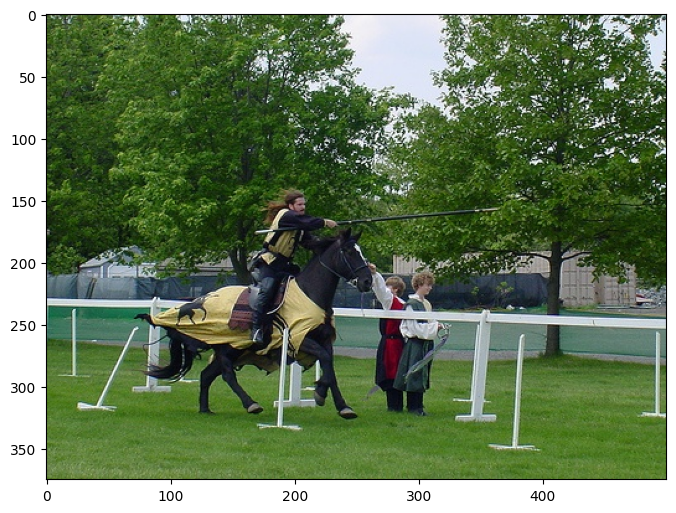

In [79]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots(1, figsize=(8,8))
ax.imshow(img)

for box, label, score in zip(boxes, labels, scores):
    x1, y1 = box[0]*img.width, box[1]*img.height
    x2, y2 = box[2]*img.width, box[3]*img.height

    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                             linewidth=2, edgecolor='g', facecolor='none')

    
    
    ax.add_patch(rect)
    # ax.text(x1, max(0, y1-5), f"{VOC_CLASSES[label]}:{score:.2f}",
    ax.text(x1, max(0, y1-5), f"{VOC_CLASSES[label]}",        
            color='red', fontsize=10)
    
    print(f"{VOC_CLASSES[label]}:{score:.2f}")

plt.show()

In [80]:
import torch

# Load the tensor
preds = torch.load("pred_epoch1.pt", map_location="cpu")  # ya "cuda" agar VRAM free hai

print(preds.shape)  # dekh le dimension kya hai

torch.Size([2, 1470])


[[1, 0, 0, 0], [1, 1, 1, 0], [0, 0, 1, 1], [1, 1, 1, 0], [1, 0, 0, 0], [0, 1, 1, 1], [0, 1, 1, 0], [1, 0, 0, 1], [0, 1, 1, 0], [0, 0, 1, 1], [1, 1, 0, 0], [0, 1, 1, 1], [0, 1, 0, 1], [1, 1, 1, 0], [1, 0, 0, 1], [1, 1, 0, 1], [0, 0, 1, 1], [1, 0, 0, 1], [1, 0, 0, 1], [1, 1, 0, 1], [0, 1, 1, 1], [0, 0, 1, 1], [0, 1, 1, 0], [1, 0, 0, 1], [1, 1, 0, 0], [1, 0, 0, 1], [1, 1, 0, 1], [1, 0, 0, 1], [1, 1, 0, 1], [0, 1, 1, 1], [1, 0, 0, 1], [0, 0, 1, 1], [1, 1, 0, 1], [0, 0, 1, 0], [1, 0, 0, 1], [1, 1, 0, 0], [0, 0, 1, 1], [1, 0, 0, 1], [1, 0, 1, 0], [1, 1, 0, 0], [1, 1, 0, 1], [1, 0, 0, 1], [0, 0, 0, 1], [0, 1, 1, 0], [1, 1, 1, 0], [1, 0, 0, 1], [0, 0, 1, 1], [0, 1, 1, 0]] [17, 15, 5, 3, 12, 12, 6, 6, 4, 16, 16, 4, 9, 15, 15, 2, 7, 7, 3, 14, 14, 13, 16, 10, 0, 9, 9, 4, 3, 2, 7, 16, 9, 9, 7, 7, 13, 11, 11, 0, 3, 9, 10, 11, 4, 4, 14, 14] [421296.09375, 576404.25, 720377.0625, 1089748.625, 1518591.0, 1628191.125, 2461208.5, 2077910.875, 2080439.375, 82958.3203125, 2343995.25, 1863138.875, 1881885.

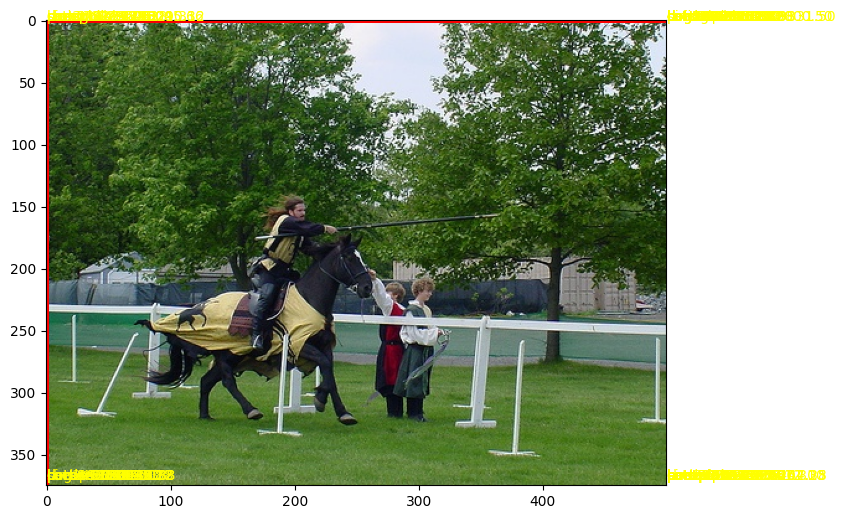

[[1, 1, 0, 0], [1, 0, 1, 0], [0, 0, 1, 1], [0, 0, 1, 0], [1, 0, 1, 1], [1, 0, 0, 0], [0, 1, 1, 1], [0, 1, 1, 0], [1, 0, 0, 1], [0, 1, 1, 0], [0, 0, 1, 1], [1, 1, 0, 0], [0, 1, 1, 0], [0, 1, 0, 1], [1, 1, 1, 1], [0, 0, 1, 1], [1, 1, 0, 1], [0, 1, 1, 0], [1, 0, 0, 1], [1, 0, 1, 1], [1, 0, 1, 1], [1, 1, 0, 1], [1, 0, 1, 1], [1, 1, 0, 1], [0, 1, 1, 0], [0, 1, 1, 1], [0, 0, 1, 1], [1, 1, 0, 0], [1, 0, 0, 1], [1, 1, 0, 1], [1, 0, 1, 1], [0, 1, 1, 0], [1, 1, 0, 0], [0, 1, 1, 1], [1, 0, 0, 1], [0, 0, 1, 1], [1, 1, 1, 1], [1, 0, 0, 0], [1, 0, 0, 0], [0, 0, 1, 0], [1, 0, 0, 0], [1, 1, 1, 0], [1, 1, 0, 1], [1, 1, 0, 0], [0, 0, 0, 0], [0, 1, 1, 0], [1, 0, 0, 1], [1, 0, 1, 1], [1, 1, 0, 1], [0, 1, 0, 1]] [17, 15, 5, 3, 0, 6, 6, 2, 2, 4, 16, 16, 4, 9, 16, 16, 2, 16, 16, 10, 4, 14, 14, 8, 8, 6, 16, 4, 9, 9, 17, 17, 17, 8, 7, 16, 9, 10, 10, 13, 11, 0, 4, 3, 10, 11, 16, 0, 18, 2] [1314752.125, 116619.3515625, 762685.875, 1527093.125, 423740.375, 1506506.0, 2475082.5, 2348066.25, 2670179.75, 2951560.75,

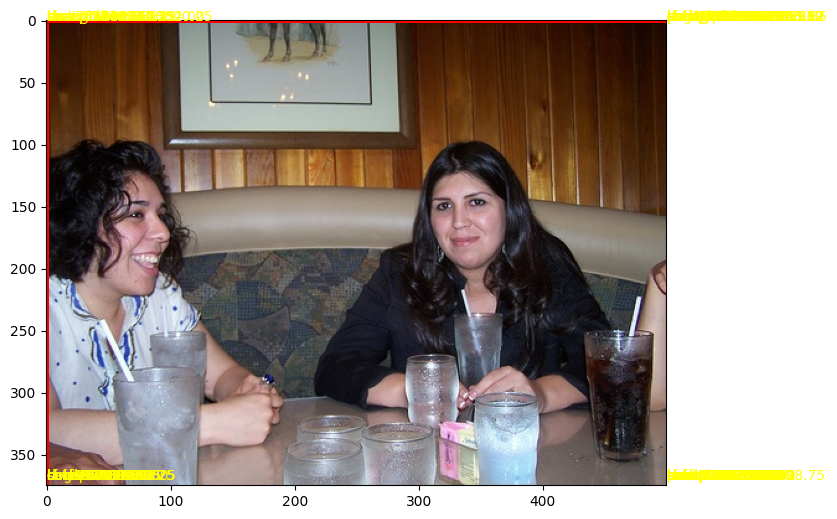

In [81]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch.nn.functional as F

# Load predictions
preds = torch.load("pred_epoch1.pt", map_location="cpu")  # [2, 1470]

S = 7
B = 2
C = 20
CONF_THRESHOLD = 1  # adjust as needed

# Decode function with clipping
def decode_yolo_output_tensor(output, conf_threshold=0.25):
    boxes = []
    labels = []
    scores = []

    # Reshape to [S, S, C + B*5]
    output = output.view(S, S, C + B*5)

    for i in range(S):
        for j in range(S):
            cell = output[i, j]
            class_probs = F.softmax(cell[:C], dim=0)
            
            for b in range(B):
                conf = cell[C + b*5]
                x = (cell[C + b*5 + 1] + j) / S
                y = (cell[C + b*5 + 2] + i) / S
                w = cell[C + b*5 + 3]
                h = cell[C + b*5 + 4]

                score = conf * class_probs.max()
                label = class_probs.argmax().item()

                if score > conf_threshold:
                    # Clip coordinates to [0,1]
                    x1 = max(0, min(1, x - w/2))
                    y1 = max(0, min(1, y - h/2))
                    x2 = max(0, min(1, x + w/2))
                    y2 = max(0, min(1, y + h/2))

                    boxes.append([x1, y1, x2, y2])
                    labels.append(label)
                    scores.append(score.item())
    
    return boxes, labels, scores

# VOC classes (20 classes)
VOC_CLASSES = [
    "aeroplane", "bicycle", "bird", "boat", "bottle",
    "bus", "car", "cat", "chair", "cow",
    "diningtable", "dog", "horse", "motorbike", "person",
    "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]

# Visualize predictions safely
for idx in range(preds.shape[0]):
    img_path = f"test_image_{idx}.jpg"  # make sure these exist
    img = Image.open(img_path).convert("RGB")
    boxes, labels, scores = decode_yolo_output_tensor(preds[idx], conf_threshold=CONF_THRESHOLD)

    print(boxes, labels, scores)

    fig, ax = plt.subplots(1, figsize=(8,8))
    ax.imshow(img)

    for box, label, score in zip(boxes, labels, scores):
        x1, y1 = box[0]*img.width, box[1]*img.height
        x2, y2 = box[2]*img.width, box[3]*img.height
    
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        
        class_name = VOC_CLASSES[label]  # assign class name
        ax.text(x1, max(0,y1-5), f"{class_name}:{score:.2f}", color='yellow', fontsize=10)

    plt.show()

In [82]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

img = Image.open("test_image.jpg").convert("RGB")  # original image

boxes, labels, scores = decode_yolo_output_tensor(preds)

fig, ax = plt.subplots(1)
ax.imshow(img)

for box, label, score in zip(boxes, labels, scores):
    x1, y1 = box[0]*img.width, box[1]*img.height
    x2, y2 = box[2]*img.width, box[3]*img.height

    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(x1, y1-5, f"{label}:{score:.2f}", color='yellow', fontsize=10)

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\deep learning\\research_paper\\YOLO\\test_image.jpg'

In [ ]:
##########################

In [ ]:
from torch import nn

class YOLO(nn.Module):
    def __init__(self, B, C):
        super().__init__()

        self.B = B
        self.C = C
        self.S = 4
        self.dropout = nn.Dropout(0.5)

        
        self.conv_1 = nn.Conv2d(in_channels = 3, out_channels=64, kernel_size=7, stride=2, padding=3) #1
        self.leaky1 = nn.LeakyReLU(0.1)
        self.max_pool_1 = nn.MaxPool2d(kernel_size=2,stride=2, padding=0) #2

        self.conv_2 = nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3, stride=1, padding=1) #3
        self.leaky2 = nn.LeakyReLU(0.1)
        self.max_pool_2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) #4

        self.conv_3 = nn.Conv2d(in_channels=192, out_channels=128, kernel_size=1, stride=1, padding=0) #5
        self.leaky3 = nn.LeakyReLU(0.1)

        self.conv_4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1) #6
        self.leaky4 = nn.LeakyReLU(0.1)

        self.conv_5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=1, stride=1, padding=0) #7
        self.leaky5 = nn.LeakyReLU(0.1)

        self.conv_6 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1) #8
        self.leaky6 = nn.LeakyReLU(0.1)
        self.max_pool_3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) #9


        # 10–17
        self.conv_7 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1, stride=1, padding=0) #10
        self.leaky7 = nn.LeakyReLU(0.1)

        self.conv_8 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1) #11
        self.leaky8 = nn.LeakyReLU(0.1)

        self.conv_9 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1, stride=1, padding=0) #12
        self.leaky9 = nn.LeakyReLU(0.1)

        self.conv_10 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1) #13
        self.leaky10 = nn.LeakyReLU(0.1)

        self.conv_11 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1, stride=1, padding=0) #14
        self.leaky11 = nn.LeakyReLU(0.1)

        self.conv_12 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1) #15
        self.leaky12 = nn.LeakyReLU(0.1)

        self.conv_13 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=1, stride=1, padding=0) #16
        self.leaky13 = nn.LeakyReLU(0.1)

        self.conv_14 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1) #17
        self.leaky14 = nn.LeakyReLU(0.1)
        self.max_pool_4 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)



        self.conv_15 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1, stride=1, padding=0) #18
        self.leaky15 = nn.LeakyReLU(0.1)

        self.conv_16 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1) #19
        self.leaky16 = nn.LeakyReLU(0.1)

        self.conv_17 = nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=1, stride=1, padding=0) #20
        self.leaky17 = nn.LeakyReLU(0.1)

        self.conv_18 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1) #21
        self.leaky18 = nn.LeakyReLU(0.1)

        self.conv_19 = nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1) #22
        self.leaky19 = nn.LeakyReLU(0.1)

        self.conv_20 = nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=2, padding=1) #23
        self.leaky20 = nn.LeakyReLU(0.1)

        self.conv_21 = nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1) #24
        self.leaky21 = nn.LeakyReLU(0.1)



        # self.fc1 = nn.Linear(in_features=7*7*1024, out_features=4096)
        # self.leaky22 = nn.LeakyReLU(0.1)
        # self.fc2 = nn.Linear(4096, 7*7*(self.B*5 + self.C))

        # self.fc1 = nn.Linear(in_features=self.S*self.S*1024, out_features=4096)
        self.fc1 = nn.Linear(1024 * self.S * self.S, 4096)
        self.leaky22 = nn.LeakyReLU(0.1)
        self.fc2 = nn.Linear(4096, self.S*self.S*(self.B*5 + self.C))

        # B = 2 (bounding boxes per grid cell)
        # C = 20 (for Pascal VOC 20 classes)


    def forward(self, x):

        out1 = self.leaky1(self.conv_1(x))
        out2 = self.max_pool_1(out1)
        
        out3 = self.leaky2(self.conv_2(out2))
        out4 = self.max_pool_2(out3)
        
        out5 = self.leaky3(self.conv_3(out4))
        out6 = self.leaky4(self.conv_4(out5))
        out7 = self.leaky5(self.conv_5(out6))
        out8 = self.leaky6(self.conv_6(out7))
        out9 = self.max_pool_3(out8)
        out10 = self.leaky7(self.conv_7(out9))
        out11 = self.leaky8(self.conv_8(out10))
        out12 = self.leaky9(self.conv_9(out11))
        out13 = self.leaky10(self.conv_10(out12))
        out14 = self.leaky11(self.conv_11(out13))
        out15 = self.leaky12(self.conv_12(out14))
        out16 = self.leaky13(self.conv_13(out15))
        out17 = self.leaky14(self.conv_14(out16))
        out18 = self.max_pool_4(out17)
        out19 = self.leaky15(self.conv_15(out18))
        out20 = self.leaky16(self.conv_16(out19))
        out21 = self.leaky17(self.conv_17(out20))
        out22 = self.leaky18(self.conv_18(out21))
        out23 = self.leaky19(self.conv_19(out22))
        out24 = self.leaky20(self.conv_20(out23))
        out25 = self.leaky21(self.conv_21(out24))
        
        out26 = out25.view(out25.size(0), -1)
        out27 = self.leaky22(self.fc1(out26))
        out28 = self.dropout(out27)
        out29 = self.fc2(out28)
        out29 = out29.view(-1, self.S, self.S, self.C + 5*self.B)
        
        return out29

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = YOLO(B=2, C=20)  # initialize model

device = "cpu"
# load checkpoint
checkpoint = torch.load("last_checkpoint.pth", map_location=device)

# load only the model weights
model.load_state_dict(checkpoint['model_state_dict'])

model.to(device)
model.eval()  # important for inference

In [ ]:
import torch
import numpy as np

def cellboxes_to_boxes(out, S=4, B=2, C=20, conf_threshold=0.5):
    """
    Convert YOLO output (SxSx(B*5+C)) into bounding boxes in image coordinates
    Returns: list of boxes [x1, y1, x2, y2, conf, class_idx]
    """
    boxes = []
    out = out.reshape(S, S, B*5 + C)
    class_probs = out[..., :C]
    box_preds = out[..., C:].reshape(S, S, B, 5)

    for i in range(S):
        for j in range(S):
            for b in range(B):
                conf = box_preds[i, j, b, 4]
                if conf < conf_threshold:
                    continue
                x, y, w, h = box_preds[i, j, b, :4]
                # Convert from cell-relative to image-relative (normalized)
                x = (j + x) / S
                y = (i + y) / S
                w = w ** 2
                h = h ** 2
                x1 = max(0, (x - w/2))
                y1 = max(0, (y - h/2))
                x2 = min(1, (x + w/2))
                y2 = min(1, (y + h/2))
                
                class_idx = torch.argmax(class_probs[i, j]).item()
                boxes.append([x1, y1, x2, y2, conf.item(), class_idx])
    return boxes

In [ ]:
import cv2
import matplotlib.pyplot as plt

VOC_CLASSES = [
    "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat",
    "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person",
    "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]

def draw_boxes(img, boxes, save_path=None):
    h, w, _ = img.shape
    for (x1, y1, x2, y2, conf, cls) in boxes:
        x1, y1, x2, y2 = int(x1*w), int(y1*h), int(x2*w), int(y2*h)
        label = f"{VOC_CLASSES[cls]}:{conf:.2f}"
        print(label)
        color = (0, 255, 0)
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
        cv2.putText(img, label, (x1, max(20, y1-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)

    if save_path:
        cv2.imwrite(save_path, img)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

In [ ]:
# Load best model
# checkpoint = torch.load("best_model.pth", map_location=device)
# model.load_state_dict(checkpoint["model_state_dict"])
# model.eval()

# Choose random image
img_path = "data/train/images/000050.jpg"
# img_path = "sheep.jpg"
orig_img = cv2.imread(img_path)
img = cv2.resize(orig_img, (224, 224))
img_tensor = torch.from_numpy(img.transpose(2, 0, 1)).float().unsqueeze(0) / 255.0
img_tensor = img_tensor.to(device)
# print(img_tensor)

# Predict
with torch.no_grad():
    pred = model(img_tensor)
# print(pred[0, :, :, -20:]) 
boxes = cellboxes_to_boxes(pred.squeeze(0).cpu(), conf_threshold=0.5)
print(boxes)

# Draw boxes
draw_boxes(orig_img.copy(), boxes)

In [ ]:
# [[tensor(0.2939), tensor(0.4273), tensor(0.4567), tensor(0.7179), 0.5183939933776855, 14], [tensor(0.4770), tensor(0.4159), tensor(0.6900), tensor(0.7456), 0.602836012840271, 14]]
# person:0.52
# person:0.60

In [ ]:
# [[tensor(0.3556), tensor(0.4351), tensor(0.4977), tensor(0.7459), 0.6378333568572998, 14], [tensor(0.4859), tensor(0.4310), tensor(0.7078), tensor(0.7511), 0.6496987342834473, 14]]

In [ ]:
print(checkpoint.keys())

In [ ]:
print(checkpoint['epoch'] if 'epoch' in checkpoint else 'No epoch info')

In [ ]:
missing, unexpected = model.load_state_dict(checkpoint['model_state_dict'], strict=False)
print("Missing:", missing)
print("Unexpected:", unexpected)

In [ ]:
img1 = torch.randn(1, 3, 224, 224)
img2 = torch.randn(1, 3, 224, 224)
with torch.no_grad():
    p1 = model(img1).cpu()
    p2 = model(img2).cpu()
print("Random input diff:", torch.mean(torch.abs(p1 - p2)))

In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [ ]:
class YOLOdataset(Dataset):
    def __init__(self, image_dir, annot_dir, S=4, B=2, C=20, transform=None):
        self.image_dir = image_dir
        self.annot_dir = annot_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]
        self.S, self.B, self.C = S, B, C
        self.transform = transform

        self.classes = [
            "aeroplane", "bicycle", "bird", "boat", "bottle",
            "bus", "car", "cat", "chair", "cow", "diningtable",
            "dog", "horse", "motorbike", "person", "pottedplant",
            "sheep", "sofa", "train", "tvmonitor"
        ]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_filename = self.image_files[idx]
        image_path = os.path.join(self.image_dir, img_filename)
        annot_path = os.path.join(self.annot_dir, img_filename.replace(".jpg", ".xml"))

        image = Image.open(image_path).convert("RGB")
        boxes, labels = self.parse_voc_xml(annot_path, image.size)
        target = self.encode_target(boxes, labels)

        if self.transform:
            image = self.transform(image)
        return image, target

    def parse_voc_xml(self, xml_path, image_size):
        boxes, labels = [], []
        tree = ET.parse(xml_path)
        root = tree.getroot()
        w, h = image_size

        for obj in root.findall("object"):
            label = obj.find("name").text
            xml_box = obj.find("bndbox")
            xmin = float(xml_box.find("xmin").text)
            ymin = float(xml_box.find("ymin").text)
            xmax = float(xml_box.find("xmax").text)
            ymax = float(xml_box.find("ymax").text)

            x_center = ((xmin + xmax) / 2) / w
            y_center = ((ymin + ymax) / 2) / h
            box_w = (xmax - xmin) / w
            box_h = (ymax - ymin) / h

            boxes.append([x_center, y_center, box_w, box_h])
            labels.append(self.classes.index(label))
        return boxes, labels

    def encode_target(self, boxes, labels):
        S, B, C = self.S, self.B, self.C
        target = torch.zeros((S, S, C + 5 * B))

        for box, label in zip(boxes, labels):
            x, y, w, h = box
            grid_x = min(int(S * x), S - 1)
            grid_y = min(int(S * y), S - 1)
            x_cell = S * x - grid_x
            y_cell = S * y - grid_y

            # fill first box
            target[grid_y, grid_x, 0:5] = torch.tensor([x_cell, y_cell, w, h, 1])
            # class one-hot
            target[grid_y, grid_x, 5 * B + label] = 1

        return target

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [ ]:
import os
test_dataset = YOLOdataset(
    image_dir="data/test/Images",
    annot_dir="data/test/labels",
    transform=transform
)

test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [ ]:
import torch
from tqdm import tqdm

def get_bboxes(loader, model, iou_threshold, threshold, box_format="midpoint", device="cuda"):
    all_pred_boxes = []
    all_true_boxes = []
    model.eval()
    train_idx = 0

    for x, y in tqdm(loader):
        x = x.to(device)
        y = y.to(device)

        with torch.no_grad():
            preds = model(x)
        # Convert model output to bounding boxes
        batch_bboxes = cellboxes_to_boxes(preds)
        true_bboxes = cellboxes_to_boxes(y)

        # Filter predictions based on confidence
        for idx in range(len(batch_bboxes)):
            nms_boxes = non_max_suppression(
                batch_bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes

In [ ]:
import torch

def cellboxes_to_boxes(out, S=4, B=2, C=20):
    """
    Converts YOLO grid output (SxSx(C+5B)) into list of [class, conf, x, y, w, h].
    Works for both predictions and targets.
    """
    out = out.to("cpu")
    batch_size = out.shape[0]
    boxes_all = []

    for i in range(batch_size):
        boxes_img = []
        for y in range(S):
            for x in range(S):
                cell = out[i, y, x]
                class_scores = cell[5 * B:]
                class_pred = torch.argmax(class_scores)
                class_conf = class_scores[class_pred]

                # pick the box with highest objectness
                box_confidences = cell[4:5*B:5]
                best_box = torch.argmax(box_confidences)
                conf = box_confidences[best_box]

                bx = (cell[best_box * 5 + 0] + x) / S
                by = (cell[best_box * 5 + 1] + y) / S
                bw = cell[best_box * 5 + 2]
                bh = cell[best_box * 5 + 3]

                boxes_img.append([
                    int(class_pred), conf.item(), bx.item(), by.item(), bw.item(), bh.item()
                ])
        boxes_all.append(boxes_img)
    return boxes_all

In [ ]:
def iou(box1, box2, box_format="midpoint"):
    if box_format == "midpoint":
        x1_min = box1[2] - box1[4]/2
        y1_min = box1[3] - box1[5]/2
        x1_max = box1[2] + box1[4]/2
        y1_max = box1[3] + box1[5]/2

        x2_min = box2[2] - box2[4]/2
        y2_min = box2[3] - box2[5]/2
        x2_max = box2[2] + box2[4]/2
        y2_max = box2[3] + box2[5]/2
    else:
        raise ValueError("Only midpoint format supported")

    inter_x1 = max(x1_min, x2_min)
    inter_y1 = max(y1_min, y2_min)
    inter_x2 = min(x1_max, x2_max)
    inter_y2 = min(y1_max, y2_max)

    inter_area = max(inter_x2 - inter_x1, 0) * max(inter_y2 - inter_y1, 0)
    box1_area = abs((x1_max - x1_min) * (y1_max - y1_min))
    box2_area = abs((x2_max - x2_min) * (y2_max - y2_min))

    return inter_area / (box1_area + box2_area - inter_area + 1e-6)


def non_max_suppression(boxes, iou_threshold, threshold, box_format="midpoint"):
    boxes = [box for box in boxes if box[1] > threshold]
    boxes.sort(key=lambda x: x[1], reverse=True)
    final_boxes = []

    while boxes:
        chosen_box = boxes.pop(0)
        boxes = [
            box for box in boxes
            if box[0] != chosen_box[0] or iou(chosen_box, box, box_format) < iou_threshold
        ]
        final_boxes.append(chosen_box)

    return final_boxes

In [ ]:
def mean_average_precision(pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20):
    """
    Compute mAP (mean average precision) for YOLOv1 predictions.
    pred_boxes and true_boxes: [ [img_idx, class, conf, x, y, w, h], ... ]
    """
    average_precisions = []
    epsilon = 1e-6

    for c in range(num_classes):
        detections = [d for d in pred_boxes if d[1] == c]
        ground_truths = [g for g in true_boxes if g[1] == c]

        if len(ground_truths) == 0:
            continue

        # count ground truths per image
        amount_bboxes = {}
        for gt in ground_truths:
            img_idx = gt[0]
            amount_bboxes[img_idx] = amount_bboxes.get(img_idx, 0) + 1

        for key in amount_bboxes.keys():
            amount_bboxes[key] = torch.zeros(amount_bboxes[key])

        detections.sort(key=lambda x: x[2], reverse=True)
        TP, FP = torch.zeros(len(detections)), torch.zeros(len(detections))
        total_true_bboxes = len(ground_truths)

        for det_idx, detection in enumerate(detections):
            gt_img = [gt for gt in ground_truths if gt[0] == detection[0]]

            best_iou = 0
            best_gt_idx = -1
            for idx, gt in enumerate(gt_img):
                iou_val = intersection_over_union(torch.tensor(detection[3:]), torch.tensor(gt[3:]), box_format)
                if iou_val > best_iou:
                    best_iou = iou_val
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    TP[det_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[det_idx] = 1
            else:
                FP[det_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = TP_cumsum / (TP_cumsum + FP_cumsum + epsilon)
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        average_precisions.append(torch.trapz(precisions, recalls))

    if len(average_precisions) == 0:
        return torch.tensor(0.0)
    return sum(average_precisions) / len(average_precisions)


def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    if box_format == "midpoint":
        box1_x1 = boxes_preds[0] - boxes_preds[2] / 2
        box1_y1 = boxes_preds[1] - boxes_preds[3] / 2
        box1_x2 = boxes_preds[0] + boxes_preds[2] / 2
        box1_y2 = boxes_preds[1] + boxes_preds[3] / 2
        box2_x1 = boxes_labels[0] - boxes_labels[2] / 2
        box2_y1 = boxes_labels[1] - boxes_labels[3] / 2
        box2_x2 = boxes_labels[0] + boxes_labels[2] / 2
        box2_y2 = boxes_labels[1] + boxes_labels[3] / 2
    else:
        raise ValueError("Only midpoint format supported")

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))
    return intersection / (box1_area + box2_area - intersection + 1e-6)

In [ ]:
# --- Load Trained YOLOv1 Model ---
import xml.etree.ElementTree as ET
device = "cuda" if torch.cuda.is_available() else "cpu"

model = YOLO(B=2, C=20).to(device)
checkpoint = torch.load("last_checkpoint.pth", map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])  # ✅ fixed line
model.eval()

# --- Get Predictions and Ground Truths ---
pred_boxes, true_boxes = get_bboxes(
    test_loader,
    model,
    iou_threshold=0.5,   # IoU threshold for true positive
    threshold=0.5,       # confidence threshold
    box_format="midpoint",
    device=device
)

# --- Compute Mean Average Precision ---
mAP = mean_average_precision(
    pred_boxes,
    true_boxes,
    iou_threshold=0.5,
    box_format="midpoint",
    num_classes=20
)

print(f"\n✅ Validation mAP: {mAP.item():.4f}")

In [17]:
import torch
from torch import nn
class YOLOv1(nn.Module):
    def __init__(self, S=4, B=2, C=20, backbone='resnet18', pretrained=True):
        super(YOLOv1, self).__init__()
        self.S = S
        self.B = B
        self.C = C

        base_model = models.resnet18(weights='IMAGENET1K_V1' if pretrained else None)
        layers = list(base_model.children())[:-2]  # remove avgpool & fc layer
        self.backbone = nn.Sequential(*layers)
        out_channels = 512  # resnet18 last conv output

        # ===== 2️⃣ DETECTION HEAD =====
        # The head converts [Batch, out_channels, feature_h, feature_w]
        # to [Batch, S, S, C + 5B]

        self.conv_head = nn.Sequential(
            nn.Conv2d(out_channels, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1, inplace=True),

            nn.Conv2d(1024, (C + 5 * B), kernel_size=1)  # final prediction map
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.conv_head(x)

        # Reshape output -> [N, S, S, C + 5B]
        # (feature map size should match SxS)
        x = nn.functional.adaptive_avg_pool2d(x, (self.S, self.S))
        x = x.permute(0, 2, 3, 1)  # [N, S, S, C + 5B]
        return x

In [18]:
import torchvision.models as models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = YOLOv1(S=4, B=2, C=20)  # initialize model

device = "cpu"
# load checkpoint
checkpoint = torch.load("logs_old/last_checkpoint.pth", map_location=device)

# load only the model weights
model.load_state_dict(checkpoint['model_state_dict'])

model.to(device)
model.eval()  # important for inference

YOLOv1(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [19]:
import torch
import numpy as np

def cellboxes_to_boxes(out, S=4, B=2, C=20, conf_threshold=0.01):
    """
    Convert YOLO output (SxSx(B*5+C)) into bounding boxes in image coordinates
    Returns: list of boxes [x1, y1, x2, y2, conf, class_idx]
    """
    boxes = []
    out = out.reshape(S, S, B*5 + C)
    class_probs = out[..., :C]
    box_preds = out[..., C:].reshape(S, S, B, 5)

    for i in range(S):
        for j in range(S):
            for b in range(B):
                conf = box_preds[i, j, b, 4]
                if conf < conf_threshold:
                    continue
                x, y, w, h = box_preds[i, j, b, :4]
                # Convert from cell-relative to image-relative (normalized)
                x = (j + x) / S
                y = (i + y) / S
                w = w ** 2
                h = h ** 2
                x1 = max(0, (x - w/2))
                y1 = max(0, (y - h/2))
                x2 = min(1, (x + w/2))
                y2 = min(1, (y + h/2))
                
                class_idx = torch.argmax(class_probs[i, j]).item()
                boxes.append([x1, y1, x2, y2, conf.item(), class_idx])
    return boxes



def iou(box1, box2):
    # box: [x1, y1, x2, y2, conf, class]
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area1 + area2 - inter
    return inter / union if union > 0 else 0


def non_max_suppression(boxes, iou_threshold=0.01, conf_threshold=0.01):
    """
    boxes: list of [x1, y1, x2, y2, conf, class_idx]
    Returns: filtered boxes after NMS
    """
    boxes = [b for b in boxes if b[4] > conf_threshold]
    boxes = sorted(boxes, key=lambda x: x[4], reverse=True)
    filtered_boxes = []

    while boxes:
        chosen_box = boxes.pop(0)
        boxes = [
            box for box in boxes
            if box[5] != chosen_box[5] or iou(chosen_box, box) < iou_threshold
        ]
        filtered_boxes.append(chosen_box)

    return filtered_boxes

In [20]:
import cv2
import matplotlib.pyplot as plt

VOC_CLASSES = [
    "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat",
    "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person",
    "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]

def draw_boxes(img, boxes, save_path=None):
    h, w, _ = img.shape
    for (x1, y1, x2, y2, conf, cls) in boxes:
        x1, y1, x2, y2 = int(x1*w), int(y1*h), int(x2*w), int(y2*h)
        label = f"{VOC_CLASSES[cls]}:{conf:.2f}"
        print(label)
        color = (0, 255, 0)
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
        cv2.putText(img, label, (x1, max(20, y1-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)

    if save_path:
        cv2.imwrite(save_path, img)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

Filtered boxes: 3
horse:0.08
person:0.06
horse:0.04


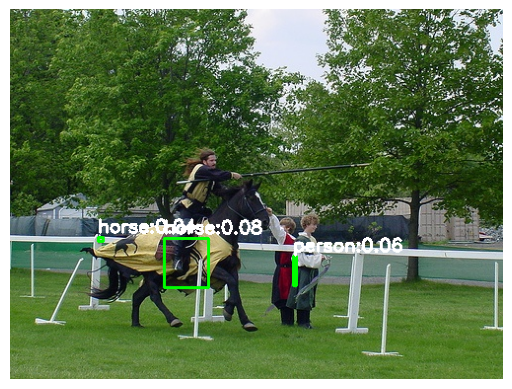

In [24]:
# Choose random image
# img_path = "data/train/images/000050.jpg"
img_path = "test_image_0.jpg"
orig_img = cv2.imread(img_path)
img = cv2.resize(orig_img, (224, 224))
img_tensor = torch.from_numpy(img.transpose(2, 0, 1)).float().unsqueeze(0) / 255.0
img_tensor = img_tensor.to(device)
# print(img_tensor)

# Predict
with torch.no_grad():
    pred = model(img_tensor)
# print(pred[0, :, :, -20:]) 
# boxes = cellboxes_to_boxes(pred.squeeze(0).cpu(), conf_threshold=0.01)
boxes = cellboxes_to_boxes(pred.squeeze(0).cpu(), conf_threshold=0.01)
boxes = non_max_suppression(boxes, iou_threshold=0.01, conf_threshold=0.01)
print(f"Filtered boxes: {len(boxes)}")

# Draw boxes
draw_boxes(orig_img.copy(), boxes)

### prediction

In [23]:
import torch
from torch import nn
class YOLOv1(nn.Module):
    def __init__(self, S=4, B=2, C=20, backbone='resnet18', pretrained=True):
        super(YOLOv1, self).__init__()
        self.S = S
        self.B = B
        self.C = C

        base_model = models.resnet18(weights='IMAGENET1K_V1' if pretrained else None)
        layers = list(base_model.children())[:-2]  # remove avgpool & fc layer
        self.backbone = nn.Sequential(*layers)
        out_channels = 512  # resnet18 last conv output

        # ===== 2️⃣ DETECTION HEAD =====
        # The head converts [Batch, out_channels, feature_h, feature_w]
        # to [Batch, S, S, C + 5B]

        self.conv_head = nn.Sequential(
            nn.Conv2d(out_channels, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1, inplace=True),

            nn.Conv2d(1024, (C + 5 * B), kernel_size=1)  # final prediction map
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.conv_head(x)

        # Reshape output -> [N, S, S, C + 5B]
        # (feature map size should match SxS)
        x = nn.functional.adaptive_avg_pool2d(x, (self.S, self.S))
        x = x.permute(0, 2, 3, 1)  # [N, S, S, C + 5B]
        return x

In [24]:
import torchvision.models as models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = YOLOv1(S=4, B=2, C=20)  # initialize model

# device = "cpu"
# load checkpoint
checkpoint = torch.load("model/best_model.pth", map_location=device)

# load only the model weights
model.load_state_dict(checkpoint['model_state_dict'])

model.to(device)
model.eval()  # important for inference

YOLOv1(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [59]:
def cellboxes_to_boxes(out, S=4, B=2, C=20, conf_threshold=0.01, img_size=(224,224)):
    out = out.reshape(S, S, B*5 + C)
    boxes = []
    img_w, img_h = img_size

    for i in range(S):
        for j in range(S):
            for b in range(B):
                tx, ty, tw, th, conf = out[i, j, 5*b : 5*b+5]
                
                if conf < conf_threshold:
                    continue

                tx = tx.item()
                ty = ty.item()
                tw = tw.item()
                th = th.item()
                conf = conf.item()
                
                # decode x, y, w, h
                x = (j + tx) / S
                y = (i + ty) / S
                w = tw ** 2
                h = th ** 2

                # convert to pixel coordinates
                x1 = (x - w/2) * img_w
                y1 = (y - h/2) * img_h
                x2 = (x + w/2) * img_w
                y2 = (y + h/2) * img_h

                # class
                class_idx = torch.argmax(out[i, j, B*5:]).item()

                boxes.append([x1, y1, x2, y2, conf, class_idx])
    return boxes

In [60]:
def intersection_over_union(boxes_preds, boxes_labels):
    # boxes_preds, boxes_labels: torch tensors [4] -> [x1, y1, x2, y2]
    box1_x1, box1_y1, box1_x2, box1_y2 = boxes_preds
    box2_x1, box2_y1, box2_x2, box2_y2 = boxes_labels

    # ensure tensors
    if not isinstance(boxes_preds, torch.Tensor):
        boxes_preds = torch.tensor(boxes_preds)
    if not isinstance(boxes_labels, torch.Tensor):
        boxes_labels = torch.tensor(boxes_labels)

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    inter = torch.clamp(x2 - x1, min=0) * torch.clamp(y2 - y1, min=0)
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return inter / (box1_area + box2_area - inter + 1e-6)

In [61]:
import torch
from collections import defaultdict

def scale_boxes(boxes, size=224):
    """Scale normalized boxes [x_center,y_center,w,h] to pixel coordinates"""
    scaled = []
    for b in boxes:
        img_idx, cls, conf, x_center, y_center, w, h = b
        x1 = (x_center - w/2) * size
        y1 = (y_center - h/2) * size
        x2 = (x_center + w/2) * size
        y2 = (y_center + h/2) * size
        scaled.append([img_idx, cls, conf, x1, y1, x2, y2])
    return scaled

def convert_gt_boxes(gt_boxes, size=224):
    """Convert GT boxes from [x_center,y_center,w,h] normalized to [x1,y1,x2,y2]"""
    converted = []
    for b in gt_boxes:
        img_idx, cls, x_center, y_center, w, h = b
        x1 = (x_center - w/2) * size
        y1 = (y_center - h/2) * size
        x2 = (x_center + w/2) * size
        y2 = (y_center + h/2) * size
        converted.append([img_idx, cls, x1, y1, x2, y2])
    return converted

def intersection_over_union(boxes_preds, boxes_labels):
    """Compute IoU for boxes in [x1,y1,x2,y2] format"""
    box1_x1, box1_y1, box1_x2, box1_y2 = boxes_preds
    box2_x1, box2_y1, box2_x2, box2_y2 = boxes_labels

    x1 = max(box1_x1, box2_x1)
    y1 = max(box1_y1, box2_y1)
    x2 = min(box1_x2, box2_x2)
    y2 = min(box1_y2, box2_y2)

    inter = max(x2 - x1, 0) * max(y2 - y1, 0)
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))
    return inter / (box1_area + box2_area - inter + 1e-6)

def mean_average_precision(pred_boxes, true_boxes, iou_threshold=0.01, num_classes=20, size=224, class_only=False):
    """
    Compute mAP or class-only accuracy.
    pred_boxes: list of [img_idx, x1, y1, x2, y2, conf, class]
    true_boxes: list of [img_idx, class, x_center, y_center, w, h] normalized
    """
    # Convert GT to pixel coordinates
    true_boxes = convert_gt_boxes(true_boxes, size=size)
    # Scale predictions
    pred_boxes = scale_boxes(pred_boxes, size=size)

    if class_only:
        # Simple class accuracy
        correct_classes = 0
        total_gt = len(true_boxes)
        gt_per_image = defaultdict(list)
        for gt in true_boxes:
            gt_per_image[gt[0]].append(gt)

        for pred in pred_boxes:
            img_idx = pred[0]
            pred_cls = pred[5]
            matched = False
            for gt in gt_per_image[img_idx]:
                if gt[1] == pred_cls:
                    correct_classes += 1
                    gt_per_image[img_idx].remove(gt)
                    matched = True
                    break
        return correct_classes / max(total_gt, 1)

    # Standard mAP computation
    average_precisions = []

    for c in range(num_classes):
        detections = [d for d in pred_boxes if d[5] == c]
        ground_truths = [t for t in true_boxes if t[1] == c]

        amount_bboxes = defaultdict(int)
        for gt in ground_truths:
            amount_bboxes[gt[0]] += 1

        for key in amount_bboxes.keys():
            amount_bboxes[key] = torch.zeros(amount_bboxes[key])

        detections.sort(key=lambda x: x[5], reverse=True)  # sort by conf
        TP = torch.zeros(len(detections))
        FP = torch.zeros(len(detections))
        total_true_bboxes = len(ground_truths)

        if total_true_bboxes == 0:
            continue

        for det_idx, detection in enumerate(detections):
            img_idx = detection[0]
            best_iou = 0
            best_gt_idx = -1

            gt_for_img = [gt for gt in ground_truths if gt[0] == img_idx]
            for idx, gt in enumerate(gt_for_img):
                iou = intersection_over_union(detection[1:5], gt[2:6])
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                if amount_bboxes[img_idx][best_gt_idx] == 0:
                    TP[det_idx] = 1
                    amount_bboxes[img_idx][best_gt_idx] = 1
                else:
                    FP[det_idx] = 1
            else:
                FP[det_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + 1e-6)
        precisions = TP_cumsum / (TP_cumsum + FP_cumsum + 1e-6)
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        average_precisions.append(torch.trapz(precisions, recalls))

    if len(average_precisions) == 0:
        return 0.0
    return sum(average_precisions) / len(average_precisions)

In [62]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import xml.etree.ElementTree as ET

class YOLOdataset(Dataset):
    def __init__(self, image_dir, annot_dir, S=4, B=2, C=20, transform=None):
        self.image_dir = image_dir
        self.annot_dir = annot_dir
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(".jpg")]
        self.S, self.B, self.C = S, B, C
        self.transform = transform

        self.classes = [
            "aeroplane", "bicycle", "bird", "boat", "bottle",
            "bus", "car", "cat", "chair", "cow", "diningtable",
            "dog", "horse", "motorbike", "person", "pottedplant",
            "sheep", "sofa", "train", "tvmonitor"
        ]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_filename = self.image_files[idx]
        image_path = os.path.join(self.image_dir, img_filename)
        annot_path = os.path.join(self.annot_dir, img_filename.replace(".jpg", ".xml"))

        image = Image.open(image_path).convert("RGB")
        boxes, labels = self.parse_voc_xml(annot_path, image.size)
        target = self.encode_target(boxes, labels)

        if self.transform:
            image = self.transform(image)
        return image, target

    def parse_voc_xml(self, xml_path, image_size):
        boxes, labels = [], []
        tree = ET.parse(xml_path)
        root = tree.getroot()
        w, h = image_size

        for obj in root.findall("object"):
            label = obj.find("name").text
            xml_box = obj.find("bndbox")
            xmin = float(xml_box.find("xmin").text)
            ymin = float(xml_box.find("ymin").text)
            xmax = float(xml_box.find("xmax").text)
            ymax = float(xml_box.find("ymax").text)

            x_center = ((xmin + xmax) / 2) / w
            y_center = ((ymin + ymax) / 2) / h
            box_w = (xmax - xmin) / w
            box_h = (ymax - ymin) / h

            boxes.append([x_center, y_center, box_w, box_h])
            labels.append(self.classes.index(label))
        return boxes, labels

    def encode_target(self, boxes, labels):
        S, B, C = self.S, self.B, self.C
        target = torch.zeros((S, S, C + 5 * B))

        for box, label in zip(boxes, labels):
            x, y, w, h = box
            grid_x = min(int(S * x), S - 1)
            grid_y = min(int(S * y), S - 1)
            x_cell = S * x - grid_x
            y_cell = S * y - grid_y

            # fill first box
            target[grid_y, grid_x, 0:5] = torch.tensor([x_cell, y_cell, w, h, 1])
            # class one-hot
            target[grid_y, grid_x, 5 * B + label] = 1

        return target

In [63]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [64]:
import os
test_dataset = YOLOdataset(
    image_dir="data/test/Images",
    annot_dir="data/test/labels",
    transform=transform
)

test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [69]:
def non_max_suppression(boxes, iou_threshold=0.01):
    """Apply NMS to filter overlapping boxes per class"""
    if len(boxes) == 0:
        return []

    boxes_tensor = torch.tensor(boxes)
    x1, y1, x2, y2, scores, classes = boxes_tensor[:,0], boxes_tensor[:,1], boxes_tensor[:,2], boxes_tensor[:,3], boxes_tensor[:,4], boxes_tensor[:,5]
    keep_boxes = []

    unique_classes = classes.unique()
    for cls in unique_classes:
        cls_mask = (classes == cls)
        cls_boxes = boxes_tensor[cls_mask]
        scores_cls = cls_boxes[:,4]
        order = scores_cls.sort(descending=True).indices
        cls_boxes = cls_boxes[order]

        while len(cls_boxes) > 0:
            box = cls_boxes[0].tolist()
            keep_boxes.append(box)
            if len(cls_boxes) == 1:
                break
            rest = cls_boxes[1:]
            xx1 = torch.max(box[0], rest[:,0])
            yy1 = torch.max(box[1], rest[:,1])
            xx2 = torch.min(box[2], rest[:,2])
            yy2 = torch.min(box[3], rest[:,3])

            w = (xx2 - xx1).clamp(min=0)
            h = (yy2 - yy1).clamp(min=0)
            inter = w * h
            iou = inter / ((box[2]-box[0])*(box[3]-box[1]) + (rest[:,2]-rest[:,0])*(rest[:,3]-rest[:,1]) - inter + 1e-6)

            cls_boxes = rest[iou < iou_threshold]

    return keep_boxes

In [70]:
def decode_predictions(pred, S=4, B=2, C=20, conf_threshold=0.01, img_shape=(224,224), nms_iou=0.5):
    """
    pred: model output [S, S, C+5B]
    Returns: list of boxes [x1,y1,x2,y2,conf,class_idx] scaled to original image with NMS
    """
    boxes = []
    H, W = img_shape

    for i in range(S):
        for j in range(S):
            cell = pred[i,j]
            for b in range(B):
                conf = cell[5*b + 4].item()
                if conf < conf_threshold:
                    continue
                x_cell = cell[5*b].item()
                y_cell = cell[5*b + 1].item()
                w = cell[5*b + 2].item() ** 2  # square if YOLO predicts sqrt(w)
                h = cell[5*b + 3].item() ** 2

                # Cell to image scale
                x_center = (j + x_cell)/S
                y_center = (i + y_cell)/S

                # Convert normalized to absolute coordinates
                x1 = int((x_center - w/2) * W)
                y1 = int((y_center - h/2) * H)
                x2 = int((x_center + w/2) * W)
                y2 = int((y_center + h/2) * H)

                # Clip boxes
                x1, y1 = max(0,x1), max(0,y1)
                x2, y2 = min(W,x2), min(H,y2)

                # Class prediction
                class_probs = cell[5*B:]
                class_idx = torch.argmax(class_probs).item()

                boxes.append([x1, y1, x2, y2, conf, class_idx])

    # Apply NMS
    boxes = non_max_suppression(boxes, iou_threshold=nms_iou)
    return boxes

In [71]:
from tqdm import tqdm

model.eval()
pred_boxes, true_boxes = [], []
S = 4  # grid size

H, W = 224, 224  # your training size

for idx, (x, y) in enumerate(tqdm(test_loader, desc="Evaluating")):
    x = x.to(device)
    with torch.no_grad():
        out = model(x)

    batch_pred = decode_predictions(out[0].cpu(), S=4, B=2, C=20, conf_threshold=0.01, img_shape=(W,H))
    batch_true = cellboxes_to_boxes(y[0], S=4, B=2, C=20)  # your GT boxes

    # Append normalized pred boxes (x_center,y_center,w,h)
    for box in batch_pred:
        x1, y1, x2, y2, conf, cls = box
        x_center = (x1 + x2) / (2*W)
        y_center = (y1 + y2) / (2*H)
        w_box = (x2 - x1) / W
        h_box = (y2 - y1) / H
        pred_boxes.append([idx, cls, conf, x_center, y_center, w_box, h_box])

    # Append normalized GT boxes
    for box in batch_true:
        x1, y1, x2, y2, conf, cls = box
        x_center = (x1 + x2) / (2*W)
        y_center = (y1 + y2) / (2*H)
        w_box = (x2 - x1) / W
        h_box = (y2 - y1) / H
        true_boxes.append([idx, cls, x_center, y_center, w_box, h_box])

# calculate mAP
map_score = mean_average_precision(pred_boxes, true_boxes, iou_threshold=0.01, num_classes=20)
print(f"mAP@0.5: {map_score:.4f}")

Evaluating:   0%|                                                                             | 0/1238 [00:00<?, ?it/s]


TypeError: max() received an invalid combination of arguments - got (float, Tensor), but expected one of:
 * (Tensor input, *, Tensor out = None)
 * (Tensor input, Tensor other, *, Tensor out = None)
 * (Tensor input, int dim, bool keepdim = False, *, tuple of Tensors out = None)
 * (Tensor input, name dim, bool keepdim = False, *, tuple of Tensors out = None)


In [73]:
import torch
import numpy as np
import cv2
from pprint import pprint

# helpers you already have or adapt from your code
# cellboxes_to_boxes(preds, S=..., conf_threshold=...) should return boxes in normalized coords [x1,y1,x2,y2,conf,class]
# If your cellboxes_to_boxes returns (cx,cy,w,h) normalized to [0,1] convert below.

def xywh_to_x1y1x2y2(box):
    # box = [cx, cy, w, h] (normalized)
    cx, cy, w, h = box
    x1 = cx - w/2
    y1 = cy - h/2
    x2 = cx + w/2
    y2 = cy + h/2
    return [x1, y1, x2, y2]

def iou_box(pred, gt):
    # all in normalized [0,1] or same scale
    x1 = max(pred[0], gt[0])
    y1 = max(pred[1], gt[1])
    x2 = min(pred[2], gt[2])
    y2 = min(pred[3], gt[3])
    inter_w = max(0, x2 - x1)
    inter_h = max(0, y2 - y1)
    inter = inter_w * inter_h
    area_p = max(0, pred[2]-pred[0]) * max(0, pred[3]-pred[1])
    area_g = max(0, gt[2]-gt[0]) * max(0, gt[3]-gt[1])
    union = area_p + area_g - inter + 1e-8
    return inter / union

# pick one sample from your test set
model.eval()
idx = 0
img, target = test_dataset[idx]   # adapt: obtain single sample (image tensor, target label structure)
# if target in VOC xml, convert to ground-truth boxes list: each as [class, x1,y1,x2,y2] normalized to [0,1]

# prepare input as you do in inference (resize to 224)
img_np = (img.numpy().transpose(1,2,0) * 255).astype(np.uint8)  # if your dataset stores normalized
orig_h, orig_w = img_np.shape[:2]
img_resized = cv2.resize(img_np, (224,224))
x = torch.from_numpy(img_resized.transpose(2,0,1)).float().unsqueeze(0)/255.0
x = x.to(device)
with torch.no_grad():
    preds = model(x)   # shape depends on your model

# decode predictions using your cellboxes_to_boxes (S must match)
boxes = cellboxes_to_boxes(preds.squeeze(0).cpu(), conf_threshold=0.01)  # ensure these are normalized to [0,1]
print("Predicted raw boxes (first 10):")
pprint(boxes[:10])

# If boxes are returned as cx,cy,w,h, convert to x1y1x2y2
converted_preds = []
for b in boxes:
    # b might be [cx,cy,w,h,conf,cls] or [x1,y1,x2,y2,conf,cls]
    if len(b) >= 6 and (b[2] < 1 and b[3] < 1 and b[0] < 1 and b[1] < 1):
        # ambiguous: check if 3rd,4th small -> probably w,h
        cx, cy, w, h, conf, cls = b[:6]
        p = xywh_to_x1y1x2y2([cx, cy, w, h])
    else:
        # assume already x1,y1,x2,y2 normalized
        p = b[:4]
        conf, cls = b[4], b[5]
    # clip
    p = [max(0, min(1, vv)) for vv in p]
    converted_preds.append([p[0], p[1], p[2], p[3], conf, cls])

pprint(converted_preds[:10])

S = 4  # grid size you used
B = 2  # number of boxes
C = 20 # number of classes

gt_boxes = []
target = target.cpu()

# Loop through each grid cell
for i in range(S):
    for j in range(S):
        cell = target[i, j]  # shape [B*5 + C]
        classes = cell[B*5:]
        class_idx = torch.argmax(classes).item()

        # check both B boxes
        for b in range(B):
            conf = cell[b*5 + 4]
            if conf > 0:  # object present
                x, y, w, h = cell[b*5:b*5+4]
                # Convert from cell-relative to image-relative normalized coords
                x = (x + j) / S
                y = (y + i) / S
                # YOLOv1 labels often store sqrt(w), sqrt(h)
                w = w ** 2
                h = h ** 2

                x1 = x - w / 2
                y1 = y - h / 2
                x2 = x + w / 2
                y2 = y + h / 2

                # Clip
                x1, y1, x2, y2 = [max(0, min(1, v)) for v in [x1, y1, x2, y2]]

                gt_boxes.append([class_idx, x1, y1, x2, y2])
print("GT boxes:", gt_boxes)

# compute IoUs between every predicted box and every GT
for i, p in enumerate(converted_preds[:20]):
    best_iou = 0
    best_gt = None
    for gt in gt_boxes:
        gt_coords = gt[1:]
        iou = iou_box(p[:4], gt_coords)
        if iou > best_iou:
            best_iou = iou
            best_gt = gt
    print(f"Pred {i}: cls={p[5]}, conf={p[4]:.3f}, best IoU={best_iou:.4f}, matched GT={best_gt}")


Predicted raw boxes (first 10):
[[-0.042728757239973936,
  -3.6750144599624512,
  0.044048567988074216,
  2.1490843831249116,
  0.1653219312429428,
  4],
 [52.50672109980362,
  -6.609758868459195,
  53.66475222449524,
  -3.7936534736123386,
  0.08912205696105957,
  16],
 [166.5271798833827,
  10.822549000961374,
  167.2748951450368,
  54.59633146168511,
  0.09043026715517044,
  16],
 [-0.9119276516188426,
  55.086164453894206,
  -0.32926647737133075,
  55.82432671460479,
  0.13585026562213898,
  15],
 [2.931394500220464,
  28.040038902161143,
  3.2245891862266793,
  89.12425027430294,
  0.0596790611743927,
  15],
 [167.91580429609792,
  56.79429977744867,
  167.9159783373408,
  56.88185559600542,
  0.26927849650382996,
  4],
 [-1.4306228876892737,
  115.68516449248628,
  -1.4305213271792718,
  115.72589381420775,
  0.1821911484003067,
  10],
 [55.71625231465732,
  112.07946186040522,
  55.71848248431052,
  112.09468070331036,
  0.047414232045412064,
  4],
 [167.4576827933589,
  112.680